In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, cv

In [3]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

In [4]:
df.columns

Index(['MainBranch', 'EdLevel', 'YearsCode', 'YearsCodePro',
       'PurchaseInfluence', 'CompTotal', 'AISelect', 'AISent', 'Frequency_1',
       'Frequency_2',
       ...
       'AIBen_', 'AIToolCurrently Using_',
       'AIToolCurrently Using_Committing and reviewing code',
       'AIToolCurrently Using_Debugging and getting help',
       'AIToolCurrently Using_Deployment and monitoring',
       'AIToolCurrently Using_Documenting code',
       'AIToolCurrently Using_Learning about a codebase',
       'AIToolCurrently Using_Project planning',
       'AIToolCurrently Using_Testing code',
       'AIToolCurrently Using_Writing code'],
      dtype='object', length=397)

# A

In [5]:
# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Reemplazar todos los NaN con 0
df.fillna(0, inplace=True)

y = df[['CompTotal']].copy()  # 'y' ahora contiene la variable objetivo

# Escalar los datos (en este caso, solo la columna de salarios)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)  # 'y_scaled' contiene los salarios escalados

# Aplicar K-Means con 4 clústeres
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(y_scaled)

# Obtener las etiquetas de los clústeres
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
df['cluster'] = labels

# Separar los grupos
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_1 = df[df['cluster'] == 1]
df_cluster_2 = df[df['cluster'] == 2]
df_cluster_3 = df[df['cluster'] == 3]

# --- Agrupar clústeres 1, 2 y 3 ---
df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})

# Separar los grupos
df_cluster_0 = df[df['cluster_grouped'] == 0]
df_cluster_1 = df[df['cluster_grouped'] == 1]

y_c0 = df_cluster_0['CompTotal']
X_c0 = df_cluster_0.drop(['CompTotal', 'cluster', 'cluster_grouped'], axis=1)

# Dividir en entrenamiento y prueba
X_train_c0, X_test_c0, y_train_c0, y_test_c0 = train_test_split(
    X_c0, y_c0, test_size=0.2, random_state=42
)

# Transformación logarítmica de la variable objetivo
y_train_c0_log = np.log1p(y_train_c0)

# Creacion de variables polinomicas
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_c0_poly = poly.fit_transform(X_train_c0)
X_test_c0_poly = poly.transform(X_test_c0)

# Obtener los nombres de las nuevas características polinómicas
poly_feature_names = poly.get_feature_names_out(input_features=X_train_c0.columns)

# Convertir las matrices NumPy a DataFrames de pandas
X_train_c0_poly = pd.DataFrame(X_train_c0_poly, columns=poly_feature_names)
X_test_c0_poly = pd.DataFrame(X_test_c0_poly, columns=poly_feature_names)

# Escalar las variables predictoras
scaler_c0 = StandardScaler()
X_train_c0_scaled = scaler_c0.fit_transform(X_train_c0_poly)
X_test_c0_scaled = scaler_c0.transform(X_test_c0_poly)

# Mejor modelo:
lgb_model = lgb.LGBMRegressor(random_state=42, objective='regression')
param_grid = {'colsample_bytree': [0.7], 'learning_rate': [0.05], 'max_depth': [5], 'min_child_samples': [1], 'n_estimators': [100], 'num_leaves': [15], 'subsample': [0.7]}
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_c0_scaled, y_train_c0_log)

print("Mejores hiperparámetros:", grid_search.best_params_)
best_lgb_model = grid_search.best_estimator_

y_pred_c0_log = best_lgb_model.predict(X_test_c0_scaled)
y_pred_c0 = np.expm1(y_pred_c0_log)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test_c0, y_pred_c0)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_c0, y_pred_c0)
r2 = r2_score(y_test_c0, y_pred_c0)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Obtener la importancia de las características
importances = best_lgb_model.feature_importances_

# Crear una Serie de pandas para facilitar la visualización
feature_importances = pd.Series(importances, index=poly_feature_names).sort_values(ascending=False)
feature_importances

C:\Users\emita\AppData\Local\Temp\ipykernel_20016\485383008.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = labels
C:\Users\emita\AppData\Local\Temp\ipykernel_20016\485383008.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.627104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246412
[LightGBM] [Info] Number of data points in the train set: 1092, number of used features: 61367
[LightGBM] [Info] Start training from score 10.510883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 1, 'n_estimators': 100, 'num_leaves': 15, 'subsample': 0.7}
MSE: 78490595.01
RMSE: 8859.49
MAE: 6742.89
R²: 0.51


LearnCode_encoded LearnCodeOnline_encoded                                       40
YearsCodePro LearnCodeOnline_encoded                                            28
CodingActivities_encoded LearnCodeOnline_encoded                                23
LearnCodeOnline_encoded DevType_encoded                                         23
YearsCodePro DevType_encoded                                                    22
                                                                                ..
LanguageHaveWorkedWith_JavaScript LanguageHaveWorkedWith_Zig                     0
LanguageHaveWorkedWith_JavaScript LanguageHaveWorkedWith_Visual Basic (.Net)     0
LanguageHaveWorkedWith_JavaScript LanguageHaveWorkedWith_VBA                     0
LanguageHaveWorkedWith_JavaScript LanguageHaveWorkedWith_TypeScript              0
AIToolCurrently Using_Writing code^2                                             0
Length: 79002, dtype: int32

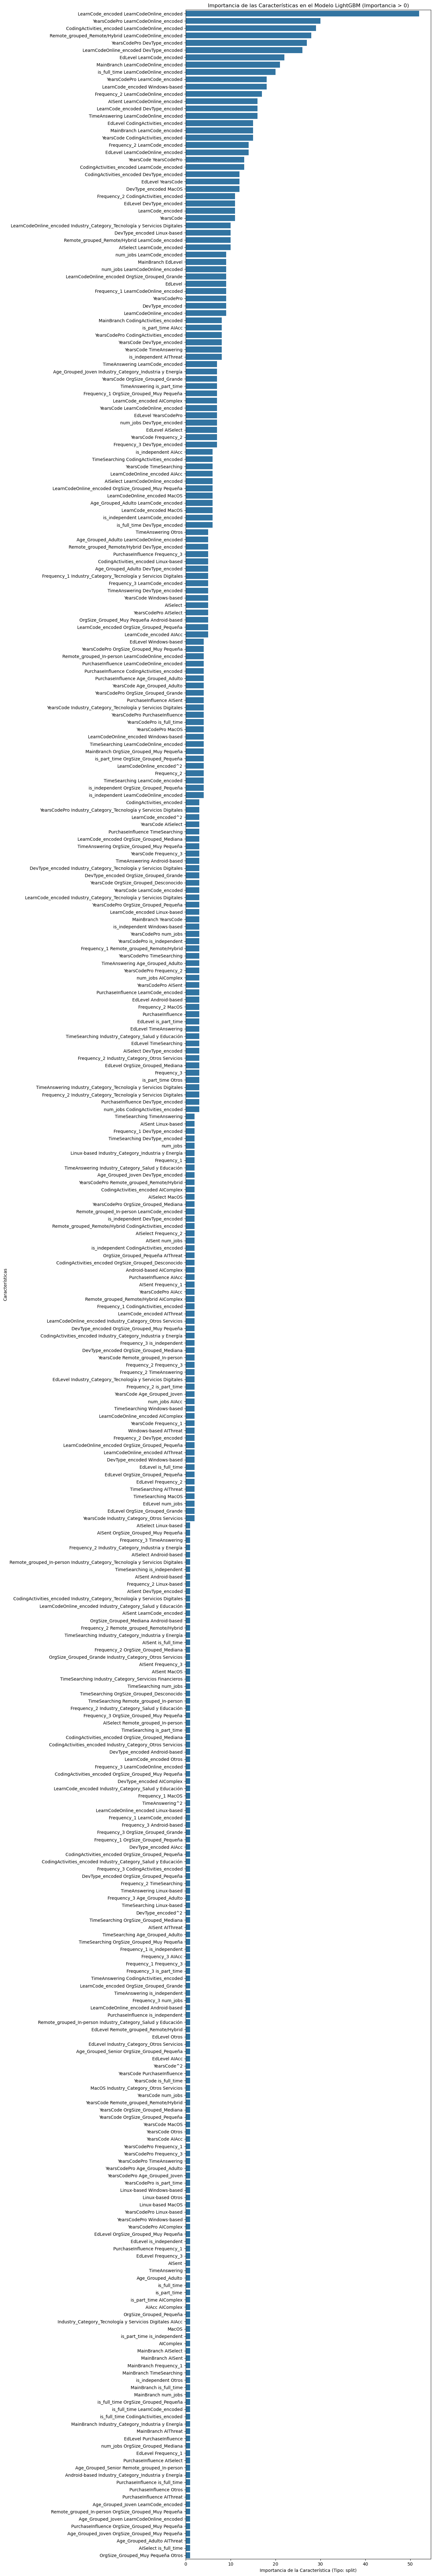

In [67]:
# Obtener la importancia de las características
importances = best_lgb_model.feature_importances_

# Crear una Serie de pandas para facilitar la visualización
feature_importances = pd.Series(importances, index=poly_feature_names).sort_values(ascending=False)

# Filtrar las características con importancia mayor que cero
non_zero_importances = feature_importances[feature_importances > 0]

# Graficar la importancia de las características (gráfico de barras horizontal)
plt.figure(figsize=(10, len(non_zero_importances) * 0.3))  # Ajustar el tamaño de la figura dinámicamente
sns.barplot(x=non_zero_importances, y=non_zero_importances.index)
plt.xlabel("Importancia de la Característica (Tipo: split)")
plt.ylabel("Características")
plt.title("Importancia de las Características en el Modelo LightGBM (Importancia > 0)")
plt.show()

In [69]:
zero_importance_features = feature_importances[feature_importances == 0].index

print(f"Variables con importancia cero: {list(zero_importance_features)}")

Variables con importancia cero: ['is_part_time AIThreat', 'num_jobs^2', 'is_independent Industry_Category_Otros Servicios', 'Remote_grouped_In-person OrgSize_Grouped_Mediana', 'is_independent Industry_Category_Salud y Educación', 'is_independent Industry_Category_Servicios Financieros', 'Remote_grouped_In-person Industry_Category_Industria y Energía', 'is_independent Industry_Category_Tecnología y Servicios Digitales', 'Remote_grouped_In-person OrgSize_Grouped_Grande', 'is_independent AIComplex', 'is_independent Age_Grouped_Desconocido', 'Remote_grouped_In-person OrgSize_Grouped_Desconocido', 'Remote_grouped_Remote/Hybrid OrgSize_Grouped_Desconocido', 'Remote_grouped_In-person Industry_Category_Otros Servicios', 'is_part_time Industry_Category_Servicios Financieros', 'num_jobs is_other_employment', 'Remote_grouped_Remote/Hybrid OrgSize_Grouped_Grande', 'num_jobs Remote_grouped_In-person', 'num_jobs Remote_grouped_Remote/Hybrid', 'Remote_grouped_Remote/Hybrid OrgSize_Grouped_Mediana', '

In [70]:
non_importance_features = feature_importances[feature_importances <= 10].index

In [71]:
importances_df = pd.DataFrame({'Feature': feature_importances.index, 'Importance': feature_importances.values})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
print(importances_df)

# Opcional: Guardar el DataFrame en un archivo CSV
importances_df.to_csv('feature_importances.csv', index=False)

                                                Feature  Importance
0             LearnCode_encoded LearnCodeOnline_encoded          52
1                  YearsCodePro LearnCodeOnline_encoded          30
2      CodingActivities_encoded LearnCodeOnline_encoded          29
3     Remote_grouped_Remote/Hybrid LearnCodeOnline_e...          28
4                          YearsCodePro DevType_encoded          27
...                                                 ...         ...
593    CodingActivities_encoded Age_Grouped_Desconocido           0
594       LearnCode_encoded OrgSize_Grouped_Desconocido           0
595       LearnCode_encoded OrgSize_Grouped_Muy Pequeña           0
596                     LearnCode_encoded Android-based           0
1079                          Age_Grouped_Desconocido^2           0

[1080 rows x 2 columns]


Ahora voy a probar el modelo LightGBM eliminando las columnas que tienen importancia cero es una excelente idea y un paso lógico en el proceso de refinamiento del modelo.

Justificación:
- Simplificación del Modelo: Eliminar variables irrelevantes simplifica el modelo, lo que puede conducir a un mejor rendimiento (menor riesgo de sobreajuste) y a una mayor interpretabilidad.
- Reducción del Ruido: Las variables con importancia cero no aportan información útil al modelo y pueden introducir ruido, lo que dificulta el aprendizaje de patrones relevantes.
- Eficiencia: Reducir el número de variables puede disminuir el tiempo de entrenamiento y el uso de memoria, especialmente si estás trabajando con un conjunto de datos muy grande.

# B

In [72]:
# --- Crear un Nuevo Conjunto de Datos sin las Variables de Importancia Cero ---

X_train_c0_reduced_poly = X_train_c0_poly.drop(non_importance_features, axis=1)
X_test_c0_reduced_poly = X_test_c0_poly.drop(non_importance_features, axis=1)

# Escalar las variables predictoras
scaler_c0 = StandardScaler()
X_train_c0_reduced_scaled = scaler_c0.fit_transform(X_train_c0_reduced_poly)
X_test_c0_reduced_scaled = scaler_c0.transform(X_test_c0_reduced_poly)

# --- Re-entrenar el Modelo LightGBM con el Conjunto de Datos Reducido ---

# Crear un nuevo modelo LightGBM (puedes usar los mismos hiperparámetros o ajustarlos de nuevo)
lgb_model_reduced = lgb.LGBMRegressor(random_state=42, objective='regression')

# Definir el param_grid (ajusta los valores según tus necesidades)
param_grid = {'colsample_bytree': [0.7], 'learning_rate': [0.05], 'max_depth': [5], 'min_child_samples': [1], 'n_estimators': [100], 'num_leaves': [15], 'subsample': [0.7]}
# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_c0_reduced_scaled, y_train_c0_log)

# Entrenar el modelo con el conjunto de datos reducido
lgb_model_reduced.fit(X_train_c0_reduced_scaled, y_train_c0_log)

# --- Evaluar el Rendimiento del Modelo con el Conjunto de Datos Reducido ---
y_pred_c0_log_reduced = grid_search.predict(X_test_c0_reduced_scaled)
y_pred_c0_reduced = np.expm1(y_pred_c0_log_reduced)

mse_reduced = mean_squared_error(y_test_c0, y_pred_c0_reduced)
rmse_reduced = np.sqrt(mse_reduced)
mae_reduced = mean_absolute_error(y_test_c0, y_pred_c0_reduced)
r2_reduced = r2_score(y_test_c0, y_pred_c0_reduced)

print(f"Métricas con variables de importancia cero eliminadas:")
print(f"MSE: {mse_reduced:.2f}")
print(f"RMSE: {rmse_reduced:.2f}")
print(f"MAE: {mae_reduced:.2f}")
print(f"R²: {r2_reduced:.2f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5941
[LightGBM] [Info] Number of data points in the train set: 1092, number of used features: 29
[LightGBM] [Info] Start training from score 10.510883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5941
[LightGBM] [Info] Number of data points in the train set: 1092, number of used features: 29
[LightGBM] [Info] Start training from score 10.510883
Métricas con variables de importancia cero eliminadas:
MSE: 77773519.60
RMSE: 8818.93
MAE: 6657.38
R²: 0.52


Sigo probadno con modelos

In [96]:
# !pip install catboost

In [6]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Reemplazar todos los NaN con 0
df.fillna(0, inplace=True)
y = df[['CompTotal']].copy()

# Aplicar K-Means con 4 clústeres
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(y)

# Obtener las etiquetas de los clústeres
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
df['cluster'] = labels

# Separar los grupos
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_1 = df[df['cluster'] == 1]
df_cluster_2 = df[df['cluster'] == 2]
df_cluster_3 = df[df['cluster'] == 3]

# --- Agrupar clústeres 1, 2 y 3 ---
df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})

# Separar los grupos
df_cluster_0 = df[df['cluster_grouped'] == 0]
df_cluster_1 = df[df['cluster_grouped'] == 1]

y = df_cluster_0['CompTotal']
X = df_cluster_0.drop(['CompTotal', 'cluster', 'cluster_grouped'], axis=1)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# NO APLICAR StandardScaler a las variables si usas CatBoost (maneja bien diferentes escalas)

# --- Entrenamiento del Modelo CatBoost ---

# Crear el modelo CatBoost
# Definir una grilla de hiperparámetros
best_params = {'colsample_bylevel': 0.7, 
              'depth': 7, 
              'grow_policy': 'Depthwise', 
              'iterations': 300, 
              'l2_leaf_reg': 7, 
              'learning_rate': 0.05, 
              'max_bin': 128, 
              'min_child_samples': 1, 
              'subsample': 0.6,
              'random_seed' : 42, 
              'loss_function' : 'RMSE', 
              'verbose' : 0
              }
# Crear el modelo CatBoost
catboost_model = CatBoostRegressor(**best_params)

catboost_model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = catboost_model.predict(X_test)

# --- Evaluación del Modelo ---

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
# --- Importancia de las Características (si es necesario) ---

feature_importances = catboost_model.get_feature_importance()

C:\Users\emita\AppData\Local\Temp\ipykernel_20016\2068603663.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = labels
C:\Users\emita\AppData\Local\Temp\ipykernel_20016\2068603663.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})


MSE: 74830415.09
RMSE: 8650.46
MAE: 6691.69
R²: 0.54


In [74]:
feature_importances

array([1.37881902e-01, 2.42511266e+00, 6.69608349e+00, 2.97147625e+01,
       9.36358642e-01, 8.92218525e-01, 1.40707002e+00, 6.01310166e-01,
       1.63078331e+00, 5.85919614e-01, 9.72335857e-01, 1.50143714e+00,
       1.89272176e-01, 1.43302561e+00, 4.47173783e-02, 1.39403897e-01,
       3.30498746e-01, 4.08762397e-01, 3.71252840e-01, 6.77398770e-03,
       6.35289660e-01, 9.85006766e-01, 3.86341108e+00, 5.17729755e+00,
       2.52299957e+01, 4.59649252e+00, 1.12060398e-01, 6.02284321e-01,
       4.28142163e-01, 7.41765489e-01, 3.71480751e-01, 5.47694887e-01,
       5.18967378e-01, 1.98109446e+00, 1.38502209e-01, 9.50128600e-01,
       1.17439217e-01, 3.33452750e-01, 2.19943500e-01, 1.88962114e-01,
       4.52032423e-01, 5.06947700e-01, 4.91195507e-01, 3.85431974e-01,
       0.00000000e+00])

In [13]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Reemplazar todos los NaN con 0
df.fillna(0, inplace=True)
y = df[['CompTotal']].copy()

# Escalar los datos (en este caso, solo la columna de salarios)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)
# Aplicar K-Means con 4 clústeres
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(y_scaled)

# Obtener las etiquetas de los clústeres
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
df['cluster'] = labels

# Separar los grupos
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_1 = df[df['cluster'] == 1]
df_cluster_2 = df[df['cluster'] == 2]
df_cluster_3 = df[df['cluster'] == 3]

# --- Agrupar clústeres 1, 2 y 3 ---
df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})

# Separar los grupos
df_cluster_0 = df[df['cluster_grouped'] == 0]
df_cluster_1 = df[df['cluster_grouped'] == 1]

y = df_cluster_0['CompTotal']
X = df_cluster_0.drop(['CompTotal', 'cluster', 'cluster_grouped'], axis=1)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scalers = StandardScaler()
X_train = scalers.fit_transform(X_train) 
X_test = scalers.transform(X_test)

# --- Entrenamiento del Modelo CatBoost ---

# Crear el modelo CatBoost
# Definir una grilla de hiperparámetros
best_params = {'colsample_bylevel': 0.7, 
              'depth': 7, 
              'grow_policy': 'Depthwise', 
              'iterations': 300, 
              'l2_leaf_reg': 7, 
              'learning_rate': 0.05, 
              'max_bin': 128, 
              'min_child_samples': 1, 
              'subsample': 0.6,
              'random_seed' : 42, 
              'loss_function' : 'RMSE', 
              'verbose' : 0
              }
# Crear el modelo CatBoost
catboost_model = CatBoostRegressor(**best_params)

# Entrenar el modelo 
catboost_model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = catboost_model.predict(X_test)

# --- Evaluación del Modelo ---

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

C:\Users\emita\AppData\Local\Temp\ipykernel_20016\1504083644.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = labels
C:\Users\emita\AppData\Local\Temp\ipykernel_20016\1504083644.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})


MSE: 74830415.09
RMSE: 8650.46
MAE: 6691.69
R²: 0.54


In [15]:
# --- Importancia de las Características (si es necesario) ---

feature_importances = catboost_model.get_feature_importance()

# Paso 1: Obtener importancias de las características y nombres
feature_names = X.columns
# Convertir las matrices NumPy a DataFrames de pandas
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)


# Crear un DataFrame para ordenar las importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Seleccionar las N características más importantes (por ejemplo, las 10 principales)
top_features = importance_df['Feature'].head(100).tolist()  # Cambia el número según desees

# Paso 2: Filtrar el DataFrame con las características seleccionadas
X_train_top = X_train_df[top_features]
X_test_top = X_test_df[top_features]

# Paso 3: Entrenar un nuevo modelo con las características más importantes
catboost_model_top = CatBoostRegressor(**best_params)
catboost_model_top.fit(X_train_top, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred_top = catboost_model_top.predict(X_test_top)

# Paso 4: Evaluar el nuevo modelo
mse_top = mean_squared_error(y_test, y_pred_top)
rmse_top = np.sqrt(mse_top)
mae_top = mean_absolute_error(y_test, y_pred_top)
r2_top = r2_score(y_test, y_pred_top)

print("\n--- Evaluación con las características más importantes ---")
print(f"MSE: {mse_top:.2f}")
print(f"RMSE: {rmse_top:.2f}")
print(f"MAE: {mae_top:.2f}")
print(f"R²: {r2_top:.2f}") 


--- Evaluación con las características más importantes ---
MSE: 70907172.24
RMSE: 8420.64
MAE: 6556.34
R²: 0.56


In [16]:
df_cluster_0

,MainBranch,EdLevel,YearsCode,YearsCodePro,PurchaseInfluence,CompTotal,AISelect,AISent,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Age_Grouped_Adulto,Age_Grouped_Joven,Age_Grouped_Senior,is_full_time,is_part_time,is_independent,num_jobs,is_other_employment,Remote_grouped_In-person,Remote_grouped_Remote/Hybrid,CodingActivities_encoded,LearnCode_encoded,LearnCodeOnline_encoded,DevType_encoded,OrgSize_Grouped_Desconocido,OrgSize_Grouped_Grande,OrgSize_Grouped_Mediana,OrgSize_Grouped_Muy Pequeña,OrgSize_Grouped_Pequeña,Android-based,Linux-based,MacOS,Otros,Windows-based,Industry_Category_Industria y Energía,Industry_Category_Otros Servicios,Industry_Category_Salud y Educación,Industry_Category_Servicios Financieros,Industry_Category_Tecnología y Servicios Digitales,BuyNewTool_Ask a generative AI tool,BuyNewTool_Ask developers I know/work with,BuyNewTool_Other,BuyNewTool_Other (please specify):,BuyNewTool_Read ratings or reviews on third party sites like G2 Crowd,BuyNewTool_Research companies that have advertised on sites I visit,BuyNewTool_Research companies that have emailed me,BuyNewTool_Start a free trial,BuyNewTool_Visit developer communities like Stack Overflow,LanguageHaveWorkedWith_,LanguageHaveWorkedWith_Ada,LanguageHaveWorkedWith_Apex,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Bash/Shell (all shells),LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_C#,LanguageHaveWorkedWith_C++,LanguageHaveWorkedWith_Clojure,LanguageHaveWorkedWith_Cobol,LanguageHaveWorkedWith_Crystal,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_F#,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_Go,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_HTML/CSS,LanguageHaveWorkedWith_Haskell,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Julia,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Nim,LanguageHaveWorkedWith_OCaml,LanguageHaveWorkedWith_Objective-C,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Prolog,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_Solidity,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Visual Basic (.Net),LanguageHaveWorkedWith_Zig,LanguageWantToWorkWith_,LanguageWantToWorkWith_Ada,LanguageWantToWorkWith_Apex,LanguageWantToWorkWith_Assembly,LanguageWantToWorkWith_Bash/Shell (all shells),LanguageWantToWorkWith_C,LanguageWantToWorkWith_C#,LanguageWantToWorkWith_C++,LanguageWantToWorkWith_Clojure,LanguageWantToWorkWith_Crystal,LanguageWantToWorkWith_Dart,LanguageWantToWorkWith_Delphi,LanguageWantToWorkWith_Elixir,LanguageWantToWorkWith_Erlang,LanguageWantToWorkWith_F#,LanguageWantToWorkWith_Fortran,LanguageWantToWorkWith_GDScript,LanguageWantToWorkWith_Go,LanguageWantToWorkWith_Groovy,LanguageWantToWorkWith_HTML/CSS,LanguageWantToWorkWith_Haskell,LanguageWantToWorkWith_Java,LanguageWantToWorkWith_JavaScript,LanguageWantToWorkWith_Julia,LanguageWantToWorkWith_Kotlin,LanguageWantToWorkWith_Lisp,LanguageWantToWorkWith_Lua,LanguageWantToWorkWith_MATLAB,LanguageWantToWorkWith_Nim,LanguageWantToWorkWith_OCaml,LanguageWantToWorkWith_Objective-C,LanguageWantToWorkWith_PHP,LanguageWantToWorkWith_Perl,LanguageWantToWorkWith_PowerShell,LanguageWantToWorkWith_Prolog,LanguageWantToWorkWith_Python,LanguageWantToWorkWith_R,LanguageWantToWorkWith_Ruby,LanguageWantToWorkWith_Rust,LanguageWantToWorkWith_SQL,LanguageWantToWorkWith_Scala,LanguageWantToWorkWith_Solidity,LanguageWantToWorkWith_Swift,LanguageWantToWorkWith_TypeScript,LanguageWantToWorkWith_VBA,LanguageWantToWorkWith_Visual Basic (.Net)

In [17]:
len(feature_importances)

396

In [19]:
importance_df.reset_index(drop=True)

,Feature,Importance
0,YearsCodePro,3.147949e+01
1,LearnCodeOnline_encoded,2.269760e+01
2,DevType_encoded,2.317076e+00
3,LearnCode_encoded,2.277594e+00
4,OfficeStackSyncHaveWorkedWith_Slack,2.246250e+00
...,...,...
391,OfficeStackSyncHaveWorkedWith_Wickr,2.785115e-36
392,LanguageWantToWorkWith_Nim,0.000000e+00
393,OfficeStackSyncHaveWorkedWith_Ringcentral,0.000000e+00
394,OfficeStackSyncHaveWorkedWith_Unify Circuit,0.000000e+00


In [20]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Reemplazar todos los NaN con 0
df.fillna(0, inplace=True)

y = df[['CompTotal']].copy()  # 'y' ahora contiene la variable objetivo

# Escalar los datos (en este caso, solo la columna de salarios)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)  # 'y_scaled' contiene los salarios escalados

# Aplicar K-Means con 4 clústeres
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(y_scaled)

# Obtener las etiquetas de los clústeres
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
df['cluster'] = labels

# Separar los grupos
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_1 = df[df['cluster'] == 1]
df_cluster_2 = df[df['cluster'] == 2]
df_cluster_3 = df[df['cluster'] == 3]

# --- Agrupar clústeres 1, 2 y 3 ---
df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})

# Separar los grupos
df_cluster_0 = df[df['cluster_grouped'] == 0]
df_cluster_1 = df[df['cluster_grouped'] == 1]

# --- CLUSTER 0 ---
y_c0 = df_cluster_0['CompTotal']
X_c0 = df_cluster_0.drop(['CompTotal', 'cluster', 'cluster_grouped'], axis=1)

# Dividir en entrenamiento y prueba
X_train_c0, X_test_c0, y_train_c0, y_test_c0 = train_test_split(
    X_c0, y_c0, test_size=0.2, random_state=42
)

# Transformación logarítmica de la variable objetivo
y_train_c0_log = np.log1p(y_train_c0)

# Creacion de variables polinomicas (si se desea)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_c0_poly = poly.fit_transform(X_train_c0)
X_test_c0_poly = poly.transform(X_test_c0)

# Obtener los nombres de las nuevas características polinómicas
poly_feature_names = poly.get_feature_names_out(input_features=X_train_c0.columns)

# Convertir las matrices NumPy a DataFrames de pandas
X_train_c0_poly = pd.DataFrame(X_train_c0_poly, columns=poly_feature_names)
X_test_c0_poly = pd.DataFrame(X_test_c0_poly, columns=poly_feature_names)

# Escalar las variables predictoras con StandardScaler
scaler_c0 = StandardScaler()
X_train_c0_scaled = scaler_c0.fit_transform(X_train_c0_poly)
X_test_c0_scaled = scaler_c0.transform(X_test_c0_poly)

# --- Entrenamiento del Modelo CatBoost (Clúster 0) ---
# Definir una grilla de hiperparámetros
param_grid = {
    'learning_rate': [0.05],
    'depth': [7],
    'l2_leaf_reg': [7],
    'iterations': [300],
    'colsample_bylevel': [0.7, 0.9],
    'subsample': [0.6, 0.8],
    'min_child_samples': [1, 10],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'max_bin': [128, 255]
}

# Crear el modelo CatBoost
catboost_model = CatBoostRegressor(random_seed=42, loss_function='RMSE', verbose=0)

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Ajustar el modelo a los datos de entrenamiento escalados y con la variable objetivo transformada
grid_search.fit(X_train_c0_scaled, y_train_c0_log)

# Mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
best_catboost_model = grid_search.best_estimator_

# --- Predicciones y Evaluación ---

# Hacer predicciones sobre el conjunto de prueba
y_pred_c0_log = best_catboost_model.predict(X_test_c0_scaled)
y_pred_c0 = np.expm1(y_pred_c0_log)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test_c0, y_pred_c0)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_c0, y_pred_c0)
r2 = r2_score(y_test_c0, y_pred_c0)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# --- Importancia de las Características ---

feature_importances = best_catboost_model.get_feature_importance()
feature_names = poly_feature_names  # Usar los nombres de las características polinómicas

# Crear un DataFrame para ordenar las importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

C:\Users\emita\AppData\Local\Temp\ipykernel_20016\1051812209.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = labels
C:\Users\emita\AppData\Local\Temp\ipykernel_20016\1051812209.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})


Fitting 3 folds for each of 48 candidates, totalling 144 fits


: 

In [77]:
df_cluster_0['Age_Grouped_Desconocido'].value_counts() # Elimino

Age_Grouped_Desconocido
0.0    1366
Name: count, dtype: int64

In [78]:
df_cluster_0['LearnCodeOnline_Category_Technical_Reference'].value_counts() # No elimino

KeyError: 'LearnCodeOnline_Category_Technical_Reference'

In [128]:
df_cluster_0['DevType_Category_Hardware y Blockchain'].value_counts() 

DevType_Category_Hardware y Blockchain
0.0    1360
1.0       6
Name: count, dtype: int64

In [129]:
df_cluster_0['DevType_Category_Gestión y Liderazgo'].value_counts() 

DevType_Category_Gestión y Liderazgo
0.0    1321
1.0      45
Name: count, dtype: int64

In [114]:
df_cluster_0['Age_Grouped_Senior'].value_counts()

Age_Grouped_Senior
0.0    1337
1.0      29
Name: count, dtype: int64

In [127]:
df_cluster_0['is_other_employment'].value_counts() # No eliminar

is_other_employment
0    1364
1       2
Name: count, dtype: int64

Pruebo de nuevo todo, quitando algunas variables:
- Age_Grouped_Desconocido: quitando la variable, el modelo mejora un 0.1 (en relacion al r2)
- is_full_time: quitando la variable, el modelo mejora un 0.1 (en relacion al r2)
- LearnCodeOnline_Category_Technical_Reference: quitandola, el modelo no mejora
- DevType_Category_Hardware y Blockchain: quitandola, el modelo no mejora
- Age_Grouped_Senior: quitandola, el modelo no mejora
- is_other_employment: quitandola, el modelo no mejora


# C

C:\Users\emita\AppData\Local\Temp\ipykernel_9028\1923579760.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = labels
C:\Users\emita\AppData\Local\Temp\ipykernel_9028\1923579760.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})


MSE: 74830415.09
RMSE: 8650.46
MAE: 6691.69
R²: 0.54


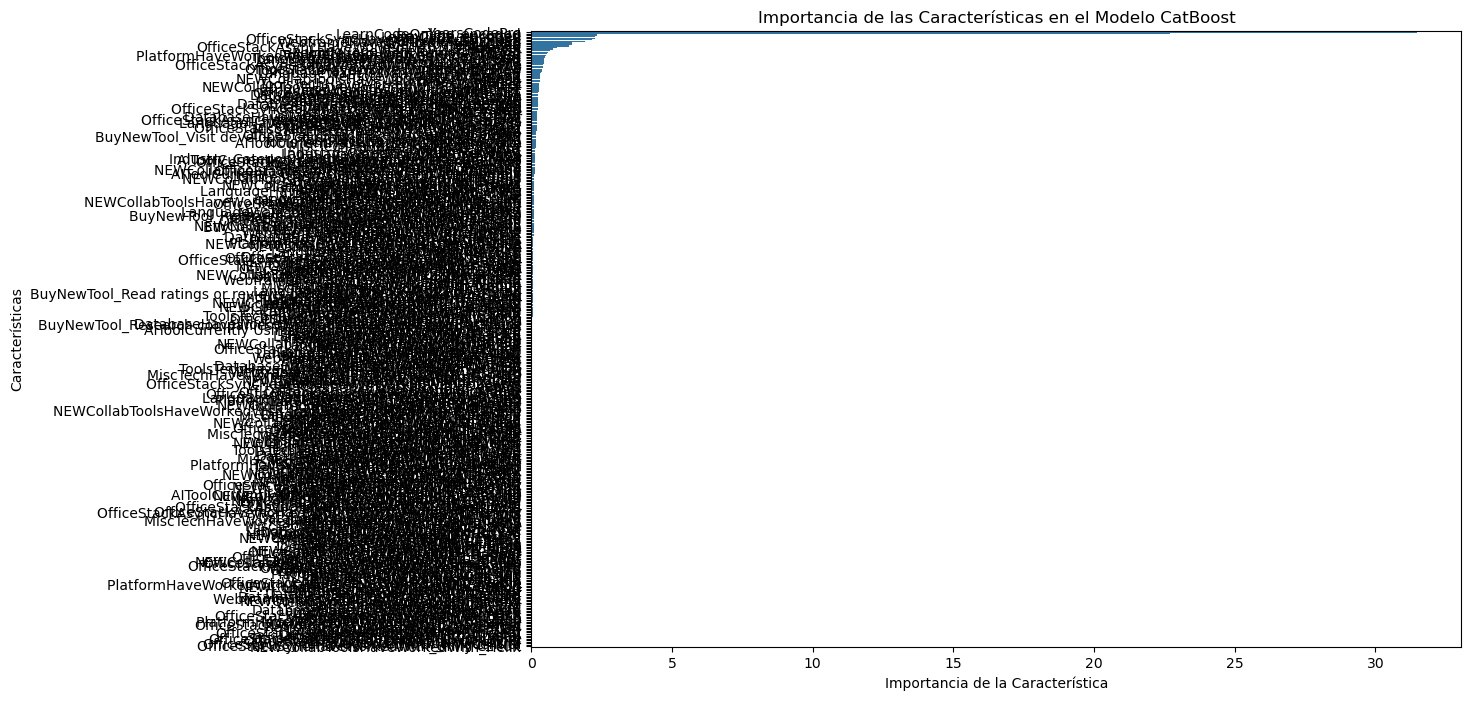

In [107]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Reemplazar todos los NaN con 0
df.fillna(0, inplace=True)
y = df[['CompTotal']].copy()

scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)
# Aplicar K-Means con 4 clústeres
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(y_scaled)

# Obtener las etiquetas de los clústeres
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
df['cluster'] = labels

# Separar los grupos
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_1 = df[df['cluster'] == 1]
df_cluster_2 = df[df['cluster'] == 2]
df_cluster_3 = df[df['cluster'] == 3]

# --- Agrupar clústeres 1, 2 y 3 ---
df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})

# Separar los grupos
df_cluster_0 = df[df['cluster_grouped'] == 0]
df_cluster_1 = df[df['cluster_grouped'] == 1]

y_c0 = df_cluster_0['CompTotal']
X_c0 = df_cluster_0.drop(['CompTotal', 'cluster', 'cluster_grouped'], axis=1)

# Dividir en entrenamiento y prueba
X_train_c0, X_test_c0, y_train_c0, y_test_c0 = train_test_split(
    X_c0, y_c0, test_size=0.2, random_state=42
)

# Guardar los nombres de las columnas originales
original_feature_names = X_train_c0.columns

# Escalar las variables predictoras con StandardScaler
scaler = StandardScaler()
X_train_c0_scaled = scaler.fit_transform(X_train_c0)
X_test_c0_scaled = scaler.transform(X_test_c0)

# Convertir los arrays escalados a DataFrames
X_train_c0 = pd.DataFrame(X_train_c0_scaled, columns=original_feature_names, index=X_train_c0.index)
X_test_c0 = pd.DataFrame(X_test_c0_scaled, columns=original_feature_names, index=X_test_c0.index)
# --- Entrenamiento del Modelo CatBoost ---

# Crear el modelo CatBoost
# Definir una grilla de hiperparámetros
best_params = {'colsample_bylevel': 0.7,
               'depth': 7,
               'grow_policy': 'Depthwise',
               'iterations': 300,
               'l2_leaf_reg': 7,
               'learning_rate': 0.05,
               'max_bin': 128,
               'min_child_samples': 1,
               'subsample': 0.6,
               'random_seed': 42,
               'loss_function': 'RMSE',
               'verbose': 0
               }
# Crear el modelo CatBoost
catboost_model = CatBoostRegressor(**best_params)

# Entrenar el modelo
catboost_model.fit(X_train_c0, y_train_c0)

# Hacer predicciones sobre el conjunto de prueba
y_pred_c0 = catboost_model.predict(X_test_c0)

# --- Evaluación del Modelo ---

mse = mean_squared_error(y_test_c0, y_pred_c0)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_c0, y_pred_c0)
r2 = r2_score(y_test_c0, y_pred_c0)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# --- Importancia de las Características (si es necesario) ---

feature_importances = catboost_model.get_feature_importance()

# Crear un DataFrame para ordenar las importancias
importance_df = pd.DataFrame({
    'Feature': original_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Seleccionar las N características más importantes (por ejemplo, las 10 principales)
top_features = importance_df['Feature'].head(20).tolist()  # Cambia el número según desees

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel("Importancia de la Característica")
plt.ylabel("Características")
plt.title("Importancia de las Características en el Modelo CatBoost")
plt.show()

# D

In [118]:
# Seleccionar las N características más importantes (por ejemplo, las 10 principales)
top_features = importance_df['Feature'].head(90).tolist()  # Cambia el número según desees

# Filtrar los DataFrames de entrenamiento y prueba para incluir solo las características seleccionadas
X_train_c0_top = X_train_c0[top_features]
X_test_c0_top = X_test_c0[top_features]

# Entrenar un nuevo modelo con las características más importantes
catboost_model_top = CatBoostRegressor(**best_params)
catboost_model_top.fit(X_train_c0_top, y_train_c0)

# Hacer predicciones sobre el conjunto de prueba con el nuevo modelo
y_pred_c0_top = catboost_model_top.predict(X_test_c0_top)

# Evaluar el nuevo modelo
mse_top = mean_squared_error(y_test_c0, y_pred_c0_top)
rmse_top = np.sqrt(mse_top)
mae_top = mean_absolute_error(y_test_c0, y_pred_c0_top)
r2_top = r2_score(y_test_c0, y_pred_c0_top)

print("\n--- Evaluación con las características más importantes ---")
print(f"MSE: {mse_top:.2f}")
print(f"RMSE: {rmse_top:.2f}")
print(f"MAE: {mae_top:.2f}")
print(f"R²: {r2_top:.2f}")


--- Evaluación con las características más importantes ---
MSE: 70742794.21
RMSE: 8410.87
MAE: 6522.00
R²: 0.56


Me quedo con los cambios realizados y sigo intentando con otras variables. 

He hecho un feature encoder de la columna 'LearnCodeOnline' y me ha mejorado significativamente el modelo. De 0.36 pasó el R2 a 0.53 con la modificación de la columna LearnCodeOnline y a 0.55 con la modificación del encoder de DevType (ambas con Target Encoder)

Seguiré cambiando la codificación de las variables, a ver si mejoran las métricas. 

In [113]:
importance_df.reset_index(drop=True).head(60)

,Feature,Importance
0,YearsCodePro,31.479486
1,LearnCodeOnline_encoded,22.697596
2,DevType_encoded,2.317076
3,LearnCode_encoded,2.277594
4,OfficeStackSyncHaveWorkedWith_Slack,2.246250
5,CodingActivities_encoded,2.146812
6,WebframeHaveWorkedWith_jQuery,1.895043
7,Age_Grouped_Joven,1.434340
8,YearsCode,1.426778
9,OfficeStackAsyncHaveWorkedWith_Confluence,1.337132


El modelo no mejora pero tampoco empeora al quitar la columna de 'Age_Grouped_Desconocido', asi que por ahora la quito. Sigo cambiando las codificaciones

Pruebo si con otro modelo mejora, pero no

# E

In [120]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)
# Reemplazar todos los NaN con 0
df.fillna(0, inplace=True)
y = df[['CompTotal']].copy()

scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)
# Aplicar K-Means con 4 clústeres
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(y_scaled)

# Obtener las etiquetas de los clústeres
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
df['cluster'] = labels

# Separar los grupos
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_1 = df[df['cluster'] == 1]
df_cluster_2 = df[df['cluster'] == 2]
df_cluster_3 = df[df['cluster'] == 3]

# --- Agrupar clústeres 1, 2 y 3 ---
df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})

# Separar los grupos
df_cluster_0 = df[df['cluster_grouped'] == 0]
df_cluster_1 = df[df['cluster_grouped'] == 1]

y_c0 = df_cluster_0['CompTotal']
X_c0 = df_cluster_0.drop(['CompTotal', 'cluster', 'cluster_grouped'], axis=1)

# Dividir en entrenamiento y prueba
X_train_c0, X_test_c0, y_train_c0, y_test_c0 = train_test_split(
    X_c0, y_c0, test_size=0.2, random_state=42
)

# Guardar los nombres de las columnas originales
original_feature_names = X_train_c0.columns

# Escalar las variables predictoras con StandardScaler
scaler = StandardScaler()
X_train_c0_scaled = scaler.fit_transform(X_train_c0)
X_test_c0_scaled = scaler.transform(X_test_c0)
X_train_c0 = pd.DataFrame(X_train_c0_scaled, columns=original_feature_names, index=X_train_c0.index)
X_test_c0 = pd.DataFrame(X_test_c0_scaled, columns=original_feature_names, index=X_test_c0.index)

# --- Entrenamiento del Modelo CatBoost ---
# Mejor modelo:
lgb_model = lgb.LGBMRegressor(random_state=42, objective='regression')
param_grid = {'colsample_bytree': [0.7], 'learning_rate': [0.05], 'max_depth': [5], 'min_child_samples': [1], 'n_estimators': [100], 'num_leaves': [15], 'subsample': [0.7]}
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_c0, y_train_c0)

print("Mejores hiperparámetros:", grid_search.best_params_)
best_lgb_model = grid_search.best_estimator_

y_pred_c0 = best_lgb_model.predict(X_test_c0)

# --- Evaluación del Modelo ---

mse = mean_squared_error(y_test_c0, y_pred_c0)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_c0, y_pred_c0)
r2 = r2_score(y_test_c0, y_pred_c0)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

C:\Users\emita\AppData\Local\Temp\ipykernel_9028\1608542213.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = labels
C:\Users\emita\AppData\Local\Temp\ipykernel_9028\1608542213.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})


Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\lightgbm\sklearn.py", line 1189, in fit
    super().fit(
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\lightgbm\sklearn.py", line 955, in fit
    self._Booster = train(
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\lightgbm\engine.py", line 282, in train
    booster = Booster(params=params, train_set=train_set)
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\lightgbm\basic.py", line 3637, in __init__
    train_set.construct()
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\lightgbm\basic.py", line 2576, in construct
    self._lazy_init(
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\lightgbm\basic.py", line 2208, in _lazy_init
    return self.set_feature_name(feature_name)
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\lightgbm\basic.py", line 3032, in set_feature_name
    _safe_call(
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\lightgbm\basic.py", line 296, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode("utf-8"))
lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name.


In [3]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Reemplazar todos los NaN con 0
df.fillna(0, inplace=True)
y = df[['CompTotal']].copy()

scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)
# Aplicar K-Means con 4 clústeres
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(y_scaled)

# Obtener las etiquetas de los clústeres
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
df['cluster'] = labels

# Separar los grupos
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_1 = df[df['cluster'] == 1]
df_cluster_2 = df[df['cluster'] == 2]
df_cluster_3 = df[df['cluster'] == 3]

# --- Agrupar clústeres 1, 2 y 3 ---
df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})

# Separar los grupos
df_cluster_0 = df[df['cluster_grouped'] == 0]
df_cluster_1 = df[df['cluster_grouped'] == 1]

y_c0 = df_cluster_0['CompTotal']
X_c0 = df_cluster_0.drop(['CompTotal', 'cluster', 'cluster_grouped'], axis=1)

# Dividir en entrenamiento y prueba
X_train_c0, X_test_c0, y_train_c0, y_test_c0 = train_test_split(
    X_c0, y_c0, test_size=0.2, random_state=42
)

# Guardar los nombres de las columnas originales
original_feature_names = X_train_c0.columns

# Escalar las variables predictoras con StandardScaler
scaler = StandardScaler()
X_train_c0_scaled = scaler.fit_transform(X_train_c0)
X_test_c0_scaled = scaler.transform(X_test_c0)

# Convertir los arrays escalados a DataFrames
X_train_c0 = pd.DataFrame(X_train_c0_scaled, columns=original_feature_names, index=X_train_c0.index)
X_test_c0 = pd.DataFrame(X_test_c0_scaled, columns=original_feature_names, index=X_test_c0.index)


# --- Entrenamiento del Modelo ---
import xgboost as xgb
# Crear un modelo de XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # objective es importante para problemas de regresión

param_grid = {
    'max_depth': [5],
    'learning_rate': [0.05],
    'n_estimators': [300, 400],
    'colsample_bytree': [0.6, 0.7,],
    'subsample': [0.6, 0.7],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_c0_scaled, y_train_c0)

print("Mejores hiperparámetros:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

# Evaluar el mejor modelo
y_pred = best_xgb_model.predict(X_test_c0_scaled)          

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test_c0, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_c0, y_pred)
r2 = r2_score(y_test_c0, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

C:\Users\emita\AppData\Local\Temp\ipykernel_17928\185924325.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = labels
C:\Users\emita\AppData\Local\Temp\ipykernel_17928\185924325.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_grouped'] = df['cluster'].map({0: 0, 1: 1, 2: 1, 3: 1})


Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
MSE: 77575611.35
RMSE: 8807.70
MAE: 6771.69
R²: 0.52
